In [229]:
ticker = "BBAS3.SA"
data = yf.Ticker(ticker).history(period="5y")  # Aumentar o período para 5 anos

data['next_day_close'] = data['Close'].shift(-1)
data['prev_day_close'] = data['Close'].shift(1)
data['close_5_days_ago'] = data['Close'].shift(5)
data['close_10_days_ago'] = data['Close'].shift(10)
data['close_20_days_ago'] = data['Close'].shift(20)

# Criação de novas features: médias móveis, volatilidade e retornos
data['ma_5'] = data['Close'].rolling(window=5).mean()
data['ma_10'] = data['Close'].rolling(window=10).mean()
data['ma_20'] = data['Close'].rolling(window=20).mean()
data['volatility'] = data['Close'].rolling(window=5).std()
data['returns'] = data['Close'].pct_change()
data['returns_5'] = data['Close'].pct_change(5)
data['returns_10'] = data['Close'].pct_change(10)

data.dropna(inplace=True)

data['price_increase'] = (data['next_day_close'] > data['Close']).astype(int)


In [230]:
train_data = data.iloc[0:int(len(data)*0.8)]
test_data = data.iloc[int(len(data)*0.8):]


In [231]:
features = ['Close', 'Volume', 'price_increase', 'prev_day_close', 'close_5_days_ago']
X_train = train_data[features]
X_test = test_data[features]
y_train = train_data['next_day_close']
y_test = test_data['next_day_close']


In [232]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [233]:
model = RandomForestRegressor(
    n_estimators=1000, max_depth=15, min_samples_split=5,
    min_samples_leaf=1, max_features='sqrt', random_state=42
)

model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=5,
                      n_estimators=1000, random_state=42)

In [234]:
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
features_df.sort_values(by='Importance', ascending=False, inplace=True)
print(features_df)


            Feature  Importance
0             Close    0.437503
3    prev_day_close    0.333603
4  close_5_days_ago    0.212729
1            Volume    0.012905
2    price_increase    0.003260


In [235]:
important_features = features_df[features_df['Importance'] > 0.05]['Feature'].tolist()
X_train_important = train_data[important_features]
X_test_important = test_data[important_features]

X_train_important_scaled = scaler.fit_transform(X_train_important)
X_test_important_scaled = scaler.transform(X_test_important)

model.fit(X_train_important_scaled, y_train)
y_pred = model.predict(X_test_important_scaled)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Erro Médio Absoluto (MAE): {mae}")
print(f"Erro Quadrático Médio (MSE): {mse}")
print(f"Coeficiente de Determinação (R2): {r2}")


Erro Médio Absoluto (MAE): 2.260797227432153
Erro Quadrático Médio (MSE): 7.2281449836692415
Coeficiente de Determinação (R2): -0.5289243447945815


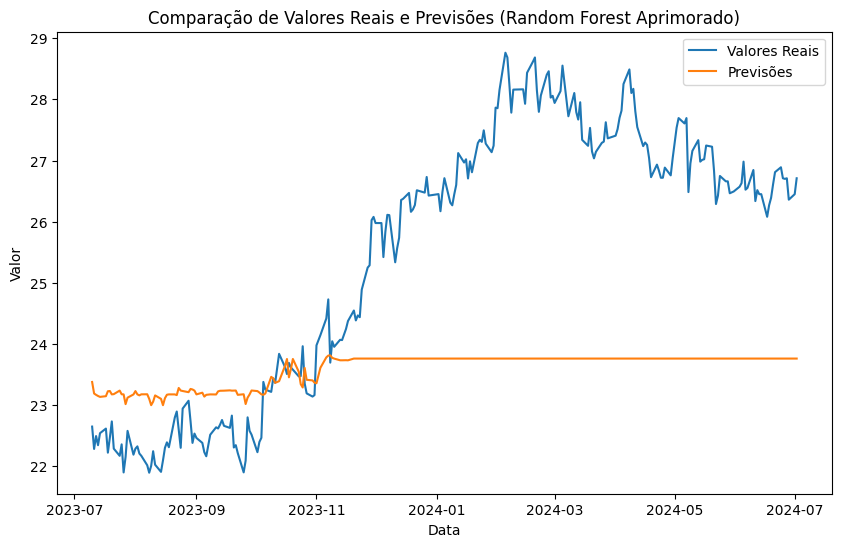

In [236]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Valores Reais')
plt.plot(y_test.index, y_pred, label='Previsões')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.title('Comparação de Valores Reais e Previsões (Random Forest Aprimorado)')
plt.legend()
plt.show()
